In [1]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
from LightEnv1 import LightEnv1 #Change this to wherever LightEnv module is kept

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 2: Let There Be Light!"

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion
class LightEnvWrapperRandom(gym.Env, LightEnv1):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.torch_collected = False
        self.torch_collected_count = []
        self.mygame = LightEnv1
        self.steps_taken = 0
        #The action space is a choice of 4 actions: U/D/L/R.
        self.action_space = Discrete(4)
        
        #The observation space is a fixed image of the current game screen
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
    def reset(self):
        print("resetting in wrapper")
        
        if self.torch_collected == 1:
            print("Torch was collected this episode!")
        else:
            print("Torch was not collected this episode...")
        self.torch_collected_count.append(self.torch_collected)
        print(self.torch_collected_count)

        self.render(self)
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        self.mygame.on_draw(self)
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
        self.steps_taken = 0
        return obs

    def step(self, action):
        self.steps_taken += 1
        
        #Making sure an action is chosen, either: 0, 1, 2, 3.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
#         print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render(self)
#         print("env rendered")
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done, torch_collected, fps_check = self.mygame.step(self,actions_myenv)
        if torch_collected == True:
            self.torch_collected = 1
        else:
            self.torch_collected = 0
                    
        if self.steps_taken % 100 == 0: #33 steps roughly equates to 1 second in game time
            print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
            print(f"steps taken: {self.steps_taken}")
#             print(f"FPS is currently: {fps_check}")
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            print(f"steps taken: {self.steps_taken}")
            obs.show()
            self.reset()
        
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #resizing and converting to array for rllib processing
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
        return obsarray
    
    def render(self, mode='state_pixels'):
#         self.mygame.update(self)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [2]:
batch_size = 4000
num_iterations = []
score_recorded = []
testing = LightEnvWrapperRandom()
for iterations in range(100): #Calculate range to be same as PPO wrapper based on num steps taken
    print("Start of episode: ", iterations)
    for i in range (0,batch_size):
        x = np.random.randint(0,4)
        testing.step(x)
    num_iterations.append(iterations)
    print("End of episode: ", iterations)
    


Start of episode:  0
total score is -6 at time: 2
steps taken: 100
total score is -9 at time: 3
steps taken: 200
total score is -11 at time: 5
steps taken: 300
total score is -14 at time: 7
steps taken: 400
total score is -16 at time: 8
steps taken: 500
total score is -19 at time: 10
steps taken: 600
total score is -21 at time: 12
steps taken: 700
total score is -22 at time: 13
steps taken: 800
total score is -26 at time: 15
steps taken: 900
total score is -28 at time: 17
steps taken: 1000
total score is -29 at time: 18
steps taken: 1100
total score is -31 at time: 20
steps taken: 1200
total score is -35 at time: 22
steps taken: 1300
total score is -36 at time: 23
steps taken: 1400
total score is -39 at time: 25
steps taken: 1500
total score is -41 at time: 27
steps taken: 1600
total score is -42 at time: 28
steps taken: 1700
total score is -45 at time: 30
steps taken: 1800
total score is -47 at time: 32
steps taken: 1900
total score is -49 at time: 33
steps taken: 2000
total score is 

End of episode:  3
Start of episode:  4
total score is -83 at time: 72
steps taken: 4300
total score is -84 at time: 73
steps taken: 4400
total score is -86 at time: 75
steps taken: 4500
total score is -89 at time: 77
steps taken: 4600
total score is -90 at time: 78
steps taken: 4700
total score is -92 at time: 80
steps taken: 4800
total score is -94 at time: 82
steps taken: 4900
total score is -95 at time: 83
steps taken: 5000
total score is -97 at time: 85
steps taken: 5100
total score is -100 at time: 87
steps taken: 5200
total score is -101 at time: 88
steps taken: 5300
total score is -103 at time: 90
steps taken: 5400
total score is -105 at time: 92
steps taken: 5500
total score is -106 at time: 93
steps taken: 5600
total score is -109 at time: 95
steps taken: 5700
total score is -111 at time: 97
steps taken: 5800
total score is -113 at time: 98
steps taken: 5900
total score is -115 at time: 100
steps taken: 6000
total score is -117 at time: 102
steps taken: 6100
total score is -1

total score is -360 at time: 333
steps taken: 20000
total score is -362 at time: 335
steps taken: 20100
total score is -364 at time: 337
steps taken: 20200
End of episode:  7
Start of episode:  8
total score is -365 at time: 338
steps taken: 20300
total score is -367 at time: 340
steps taken: 20400
total score is -369 at time: 342
steps taken: 20500
total score is -370 at time: 343
steps taken: 20600
total score is -372 at time: 345
steps taken: 20700
total score is -374 at time: 347
steps taken: 20800
total score is -375 at time: 348
steps taken: 20900
total score is -377 at time: 350
steps taken: 21000
total score is -379 at time: 352
steps taken: 21100
total score is -380 at time: 353
steps taken: 21200
total score is -382 at time: 355
steps taken: 21300
total score is -384 at time: 357
steps taken: 21400
total score is -385 at time: 358
steps taken: 21500
total score is -387 at time: 360
steps taken: 21600
total score is -389 at time: 362
steps taken: 21700
total score is -390 at t

total score is -248 at time: 227
steps taken: 13600
total score is -249 at time: 228
steps taken: 13700
total score is -251 at time: 230
steps taken: 13800
total score is -253 at time: 232
steps taken: 13900
total score is -254 at time: 233
steps taken: 14000
total score is -256 at time: 235
steps taken: 14100
End of episode:  11
Start of episode:  12
total score is -258 at time: 237
steps taken: 14200
total score is -259 at time: 238
steps taken: 14300
total score is -261 at time: 240
steps taken: 14400
total score is -263 at time: 242
steps taken: 14500
total score is -264 at time: 243
steps taken: 14600
total score is -266 at time: 245
steps taken: 14700
total score is -268 at time: 247
steps taken: 14800
total score is -269 at time: 248
steps taken: 14900
total score is -271 at time: 250
steps taken: 15000
total score is -273 at time: 252
steps taken: 15100
total score is -274 at time: 253
steps taken: 15200
total score is -276 at time: 255
steps taken: 15300
total score is -278 at

total score is -515 at time: 485
steps taken: 29100
total score is -517 at time: 487
steps taken: 29200
total score is -518 at time: 488
steps taken: 29300
total score is -520 at time: 490
steps taken: 29400
total score is -522 at time: 492
steps taken: 29500
total score is -523 at time: 493
steps taken: 29600
total score is -525 at time: 495
steps taken: 29700
total score is -527 at time: 497
steps taken: 29800
total score is -528 at time: 498
steps taken: 29900
total score is -530 at time: 500
steps taken: 30000
total score is -532 at time: 502
steps taken: 30100
End of episode:  15
Start of episode:  16
total score is -533 at time: 503
steps taken: 30200
total score is -535 at time: 505
steps taken: 30300
total score is -537 at time: 507
steps taken: 30400
total score is -538 at time: 508
steps taken: 30500
total score is -540 at time: 510
steps taken: 30600
total score is -542 at time: 512
steps taken: 30700
total score is -543 at time: 513
steps taken: 30800
total score is -545 at

total score is -179 at time: 157
steps taken: 9400
total score is -181 at time: 158
steps taken: 9500
total score is -183 at time: 160
steps taken: 9600
total score is -185 at time: 162
steps taken: 9700
total score is -186 at time: 163
steps taken: 9800
total score is -188 at time: 165
steps taken: 9900
total score is -190 at time: 167
steps taken: 10000
total score is -191 at time: 168
steps taken: 10100
total score is -193 at time: 170
steps taken: 10200
total score is -195 at time: 172
steps taken: 10300
total score is -196 at time: 173
steps taken: 10400
total score is -198 at time: 175
steps taken: 10500
total score is -201 at time: 177
steps taken: 10600
total score is -202 at time: 178
steps taken: 10700
total score is -204 at time: 180
steps taken: 10800
total score is -207 at time: 182
steps taken: 10900
End of episode:  19
Start of episode:  20
total score is -208 at time: 183
steps taken: 11000
total score is -210 at time: 185
steps taken: 11100
total score is -212 at time:

total score is -449 at time: 415
steps taken: 24900
total score is -451 at time: 417
steps taken: 25000
total score is -452 at time: 418
steps taken: 25100
total score is -454 at time: 420
steps taken: 25200
total score is -456 at time: 422
steps taken: 25300
total score is -457 at time: 423
steps taken: 25400
Game completed with a score of: -358 at time: 424
done is True, resetting environment in wrapper.
steps taken: 25440
resetting in wrapper
Torch was collected this episode!
[1, 0, 1, 1]
resetting
total score is -5 at time: 2
steps taken: 100
total score is -6 at time: 3
steps taken: 200
total score is -8 at time: 5
steps taken: 300
total score is -12 at time: 7
steps taken: 400
total score is -14 at time: 8
steps taken: 500
total score is -17 at time: 10
steps taken: 600
total score is -19 at time: 12
steps taken: 700
total score is -20 at time: 13
steps taken: 800
total score is -23 at time: 15
steps taken: 900
total score is -25 at time: 17
steps taken: 1000
total score is -26 a

total score is -18 at time: 12
steps taken: 700
total score is -19 at time: 13
steps taken: 800
total score is -22 at time: 15
steps taken: 900
total score is -24 at time: 17
steps taken: 1000
total score is -25 at time: 18
steps taken: 1100
total score is -28 at time: 20
steps taken: 1200
total score is -30 at time: 22
steps taken: 1300
total score is -32 at time: 23
steps taken: 1400
total score is -34 at time: 25
steps taken: 1500
total score is -36 at time: 27
steps taken: 1600
total score is -37 at time: 28
steps taken: 1700
total score is -39 at time: 30
steps taken: 1800
total score is -41 at time: 32
steps taken: 1900
total score is -43 at time: 33
steps taken: 2000
total score is -46 at time: 35
steps taken: 2100
total score is -48 at time: 37
steps taken: 2200
total score is -49 at time: 38
steps taken: 2300
total score is -51 at time: 40
steps taken: 2400
total score is -53 at time: 42
steps taken: 2500
total score is -54 at time: 43
steps taken: 2600
total score is -56 at t

total score is -310 at time: 277
steps taken: 16600
total score is -311 at time: 278
steps taken: 16700
total score is -313 at time: 280
steps taken: 16800
total score is -315 at time: 282
steps taken: 16900
total score is -316 at time: 283
steps taken: 17000
total score is -318 at time: 285
steps taken: 17100
total score is -320 at time: 287
steps taken: 17200
total score is -321 at time: 288
steps taken: 17300
total score is -323 at time: 290
steps taken: 17400
total score is -325 at time: 292
steps taken: 17500
total score is -326 at time: 293
steps taken: 17600
total score is -328 at time: 295
steps taken: 17700
total score is -331 at time: 297
steps taken: 17800
total score is -332 at time: 298
steps taken: 17900
total score is -334 at time: 300
steps taken: 18000
total score is -336 at time: 302
steps taken: 18100
total score is -337 at time: 303
steps taken: 18200
total score is -339 at time: 305
steps taken: 18300
total score is -341 at time: 307
steps taken: 18400
total score 

End of episode:  34
Start of episode:  35
total score is -112 at time: 93
steps taken: 5600
total score is -114 at time: 95
steps taken: 5700
total score is -116 at time: 97
steps taken: 5800
total score is -117 at time: 98
steps taken: 5900
total score is -119 at time: 100
steps taken: 6000
total score is -121 at time: 102
steps taken: 6100
total score is -122 at time: 103
steps taken: 6200
total score is -124 at time: 105
steps taken: 6300
total score is -126 at time: 107
steps taken: 6400
total score is -127 at time: 108
steps taken: 6500
total score is -129 at time: 110
steps taken: 6600
total score is -131 at time: 112
steps taken: 6700
total score is -132 at time: 113
steps taken: 6800
total score is -134 at time: 115
steps taken: 6900
total score is -136 at time: 117
steps taken: 7000
total score is -137 at time: 118
steps taken: 7100
total score is -139 at time: 120
steps taken: 7200
total score is -141 at time: 122
steps taken: 7300
total score is -142 at time: 123
steps taken

total score is -385 at time: 353
steps taken: 21200
total score is -387 at time: 355
steps taken: 21300
total score is -390 at time: 357
steps taken: 21400
total score is -391 at time: 358
steps taken: 21500
End of episode:  38
Start of episode:  39
total score is -393 at time: 360
steps taken: 21600
total score is -395 at time: 362
steps taken: 21700
total score is -396 at time: 363
steps taken: 21800
total score is -398 at time: 365
steps taken: 21900
total score is -400 at time: 367
steps taken: 22000
total score is -401 at time: 368
steps taken: 22100
Game completed with a score of: -304 at time: 370
done is True, resetting environment in wrapper.
steps taken: 22197
resetting in wrapper
Torch was collected this episode!
[1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
resetting
total score is -4 at time: 2
steps taken: 100
total score is -5 at time: 3
steps taken: 200
total score is -8 at time: 5
steps taken: 300
total score is -12 at time: 7
steps taken: 400
total score is -14 at time: 8
steps take

total score is -131 at time: 110
steps taken: 6600
total score is -133 at time: 112
steps taken: 6700
total score is -134 at time: 113
steps taken: 6800
total score is -136 at time: 115
steps taken: 6900
total score is -138 at time: 117
steps taken: 7000
total score is -139 at time: 118
steps taken: 7100
total score is -141 at time: 120
steps taken: 7200
total score is -143 at time: 122
steps taken: 7300
total score is -145 at time: 123
steps taken: 7400
total score is -147 at time: 125
steps taken: 7500
total score is -149 at time: 127
steps taken: 7600
total score is -150 at time: 128
steps taken: 7700
End of episode:  42
Start of episode:  43
total score is -152 at time: 130
steps taken: 7800
total score is -154 at time: 132
steps taken: 7900
total score is -156 at time: 133
steps taken: 8000
total score is -158 at time: 135
steps taken: 8100
total score is -160 at time: 137
steps taken: 8200
total score is -161 at time: 138
steps taken: 8300
total score is -165 at time: 140
steps t

total score is -86 at time: 72
steps taken: 4300
total score is -87 at time: 73
steps taken: 4400
total score is -89 at time: 75
steps taken: 4500
total score is -91 at time: 77
steps taken: 4600
total score is -92 at time: 78
steps taken: 4700
total score is -94 at time: 80
steps taken: 4800
total score is -96 at time: 82
steps taken: 4900
total score is -97 at time: 83
steps taken: 5000
total score is -99 at time: 85
steps taken: 5100
total score is -101 at time: 87
steps taken: 5200
total score is -102 at time: 88
steps taken: 5300
total score is -104 at time: 90
steps taken: 5400
total score is -106 at time: 92
steps taken: 5500
total score is -107 at time: 93
steps taken: 5600
total score is -110 at time: 95
steps taken: 5700
total score is -112 at time: 97
steps taken: 5800
total score is -113 at time: 98
steps taken: 5900
End of episode:  46
Start of episode:  47
total score is -116 at time: 100
steps taken: 6000
total score is -118 at time: 102
steps taken: 6100
total score is 

total score is -359 at time: 332
steps taken: 19900
total score is -360 at time: 333
steps taken: 20000
total score is -362 at time: 335
steps taken: 20100
total score is -364 at time: 337
steps taken: 20200
total score is -365 at time: 338
steps taken: 20300
total score is -367 at time: 340
steps taken: 20400
total score is -369 at time: 342
steps taken: 20500
total score is -370 at time: 343
steps taken: 20600
total score is -372 at time: 345
steps taken: 20700
total score is -374 at time: 347
steps taken: 20800
total score is -375 at time: 348
steps taken: 20900
total score is -377 at time: 350
steps taken: 21000
total score is -379 at time: 352
steps taken: 21100
total score is -380 at time: 353
steps taken: 21200
total score is -382 at time: 355
steps taken: 21300
total score is -384 at time: 357
steps taken: 21400
total score is -385 at time: 358
steps taken: 21500
total score is -387 at time: 360
steps taken: 21600
total score is -389 at time: 362
steps taken: 21700
total score 

total score is -621 at time: 590
steps taken: 35400
total score is -623 at time: 592
steps taken: 35500
total score is -624 at time: 593
steps taken: 35600
total score is -626 at time: 595
steps taken: 35700
total score is -628 at time: 597
steps taken: 35800
total score is -629 at time: 598
steps taken: 35900
total score is -631 at time: 600
steps taken: 36000
total score is -633 at time: 602
steps taken: 36100
total score is -634 at time: 603
steps taken: 36200
total score is -637 at time: 605
steps taken: 36300
total score is -639 at time: 607
steps taken: 36400
total score is -640 at time: 608
steps taken: 36500
total score is -642 at time: 610
steps taken: 36600
total score is -644 at time: 612
steps taken: 36700
total score is -645 at time: 613
steps taken: 36800
total score is -647 at time: 615
steps taken: 36900
Game completed with a score of: -548 at time: 616
done is True, resetting environment in wrapper.
steps taken: 36932
resetting in wrapper
Torch was collected this episo

total score is -44 at time: 32
steps taken: 1900
total score is -45 at time: 33
steps taken: 2000
total score is -47 at time: 35
steps taken: 2100
total score is -49 at time: 37
steps taken: 2200
total score is -51 at time: 38
steps taken: 2300
total score is -53 at time: 40
steps taken: 2400
total score is -55 at time: 42
steps taken: 2500
total score is -56 at time: 43
steps taken: 2600
total score is -58 at time: 45
steps taken: 2700
total score is -60 at time: 47
steps taken: 2800
total score is -61 at time: 48
steps taken: 2900
total score is -63 at time: 50
steps taken: 3000
total score is -65 at time: 52
steps taken: 3100
total score is -66 at time: 53
steps taken: 3200
total score is -68 at time: 55
steps taken: 3300
total score is -71 at time: 57
steps taken: 3400
total score is -73 at time: 58
steps taken: 3500
total score is -76 at time: 60
steps taken: 3600
total score is -78 at time: 62
steps taken: 3700
total score is -79 at time: 63
steps taken: 3800
total score is -82 a

total score is -332 at time: 297
steps taken: 17800
total score is -333 at time: 298
steps taken: 17900
total score is -335 at time: 300
steps taken: 18000
total score is -337 at time: 302
steps taken: 18100
total score is -338 at time: 303
steps taken: 18200
total score is -340 at time: 305
steps taken: 18300
total score is -342 at time: 307
steps taken: 18400
total score is -343 at time: 308
steps taken: 18500
total score is -345 at time: 310
steps taken: 18600
total score is -347 at time: 312
steps taken: 18700
total score is -348 at time: 313
steps taken: 18800
total score is -351 at time: 315
steps taken: 18900
total score is -353 at time: 317
steps taken: 19000
total score is -354 at time: 318
steps taken: 19100
total score is -356 at time: 320
steps taken: 19200
total score is -358 at time: 322
steps taken: 19300
total score is -359 at time: 323
steps taken: 19400
total score is -361 at time: 325
steps taken: 19500
total score is -363 at time: 327
steps taken: 19600
total score 

total score is -600 at time: 557
steps taken: 33400
total score is -601 at time: 558
steps taken: 33500
total score is -603 at time: 560
steps taken: 33600
End of episode:  65
Start of episode:  66
total score is -605 at time: 562
steps taken: 33700
total score is -606 at time: 563
steps taken: 33800
total score is -608 at time: 565
steps taken: 33900
total score is -610 at time: 567
steps taken: 34000
total score is -611 at time: 568
steps taken: 34100
total score is -613 at time: 570
steps taken: 34200
total score is -615 at time: 572
steps taken: 34300
total score is -616 at time: 573
steps taken: 34400
total score is -618 at time: 575
steps taken: 34500
total score is -620 at time: 577
steps taken: 34600
total score is -621 at time: 578
steps taken: 34700
total score is -623 at time: 580
steps taken: 34800
total score is -625 at time: 582
steps taken: 34900
total score is -626 at time: 583
steps taken: 35000
total score is -628 at time: 585
steps taken: 35100
total score is -630 at

total score is -204 at time: 180
steps taken: 10800
total score is -206 at time: 182
steps taken: 10900
total score is -207 at time: 183
steps taken: 11000
total score is -209 at time: 185
steps taken: 11100
total score is -213 at time: 187
steps taken: 11200
total score is -214 at time: 188
steps taken: 11300
total score is -216 at time: 190
steps taken: 11400
total score is -218 at time: 192
steps taken: 11500
total score is -219 at time: 193
steps taken: 11600
End of episode:  69
Start of episode:  70
total score is -221 at time: 195
steps taken: 11700
total score is -223 at time: 197
steps taken: 11800
total score is -224 at time: 198
steps taken: 11900
total score is -226 at time: 200
steps taken: 12000
total score is -229 at time: 202
steps taken: 12100
total score is -230 at time: 203
steps taken: 12200
total score is -232 at time: 205
steps taken: 12300
total score is -234 at time: 207
steps taken: 12400
total score is -235 at time: 208
steps taken: 12500
total score is -237 at

total score is -476 at time: 438
steps taken: 26300
total score is -478 at time: 440
steps taken: 26400
total score is -480 at time: 442
steps taken: 26500
total score is -481 at time: 443
steps taken: 26600
total score is -483 at time: 445
steps taken: 26700
total score is -485 at time: 447
steps taken: 26800
total score is -486 at time: 448
steps taken: 26900
total score is -488 at time: 450
steps taken: 27000
total score is -490 at time: 452
steps taken: 27100
total score is -491 at time: 453
steps taken: 27200
total score is -493 at time: 455
steps taken: 27300
total score is -495 at time: 457
steps taken: 27400
total score is -496 at time: 458
steps taken: 27500
total score is -498 at time: 460
steps taken: 27600
End of episode:  73
Start of episode:  74
total score is -500 at time: 462
steps taken: 27700
total score is -501 at time: 463
steps taken: 27800
total score is -503 at time: 465
steps taken: 27900
total score is -505 at time: 467
steps taken: 28000
total score is -506 at

total score is -740 at time: 697
steps taken: 41800
total score is -741 at time: 698
steps taken: 41900
total score is -743 at time: 700
steps taken: 42000
total score is -745 at time: 702
steps taken: 42100
total score is -746 at time: 703
steps taken: 42200
total score is -748 at time: 705
steps taken: 42300
total score is -750 at time: 707
steps taken: 42400
total score is -751 at time: 708
steps taken: 42500
total score is -753 at time: 710
steps taken: 42600
total score is -755 at time: 712
steps taken: 42700
total score is -756 at time: 713
steps taken: 42800
total score is -758 at time: 715
steps taken: 42900
total score is -761 at time: 717
steps taken: 43000
total score is -762 at time: 718
steps taken: 43100
total score is -764 at time: 720
steps taken: 43200
total score is -766 at time: 722
steps taken: 43300
total score is -767 at time: 723
steps taken: 43400
total score is -769 at time: 725
steps taken: 43500
total score is -772 at time: 727
steps taken: 43600
End of episo

total score is -180 at time: 160
steps taken: 9600
total score is -182 at time: 162
steps taken: 9700
total score is -183 at time: 163
steps taken: 9800
total score is -185 at time: 165
steps taken: 9900
total score is -187 at time: 167
steps taken: 10000
total score is -188 at time: 168
steps taken: 10100
total score is -190 at time: 170
steps taken: 10200
total score is -192 at time: 172
steps taken: 10300
total score is -193 at time: 173
steps taken: 10400
total score is -195 at time: 175
steps taken: 10500
total score is -197 at time: 177
steps taken: 10600
total score is -199 at time: 178
steps taken: 10700
total score is -201 at time: 180
steps taken: 10800
total score is -203 at time: 182
steps taken: 10900
total score is -204 at time: 183
steps taken: 11000
total score is -206 at time: 185
steps taken: 11100
total score is -208 at time: 187
steps taken: 11200
total score is -209 at time: 188
steps taken: 11300
total score is -211 at time: 190
steps taken: 11400
total score is -

total score is -454 at time: 418
steps taken: 25100
total score is -456 at time: 420
steps taken: 25200
total score is -458 at time: 422
steps taken: 25300
total score is -459 at time: 423
steps taken: 25400
total score is -461 at time: 425
steps taken: 25500
total score is -463 at time: 427
steps taken: 25600
total score is -464 at time: 428
steps taken: 25700
total score is -466 at time: 430
steps taken: 25800
total score is -468 at time: 432
steps taken: 25900
total score is -469 at time: 433
steps taken: 26000
total score is -471 at time: 435
steps taken: 26100
total score is -473 at time: 437
steps taken: 26200
total score is -474 at time: 438
steps taken: 26300
total score is -476 at time: 440
steps taken: 26400
total score is -478 at time: 442
steps taken: 26500
total score is -479 at time: 443
steps taken: 26600
total score is -481 at time: 445
steps taken: 26700
total score is -483 at time: 447
steps taken: 26800
total score is -484 at time: 448
steps taken: 26900
total score 

total score is -719 at time: 677
steps taken: 40600
total score is -720 at time: 678
steps taken: 40700
total score is -722 at time: 680
steps taken: 40800
total score is -724 at time: 682
steps taken: 40900
total score is -725 at time: 683
steps taken: 41000
total score is -727 at time: 685
steps taken: 41100
total score is -729 at time: 687
steps taken: 41200
total score is -730 at time: 688
steps taken: 41300
total score is -732 at time: 690
steps taken: 41400
total score is -734 at time: 692
steps taken: 41500
total score is -735 at time: 693
steps taken: 41600
total score is -737 at time: 695
steps taken: 41700
total score is -739 at time: 697
steps taken: 41800
total score is -740 at time: 698
steps taken: 41900
total score is -742 at time: 700
steps taken: 42000
total score is -744 at time: 702
steps taken: 42100
total score is -745 at time: 703
steps taken: 42200
total score is -747 at time: 705
steps taken: 42300
total score is -749 at time: 707
steps taken: 42400
total score 

total score is -982 at time: 935
steps taken: 56100
total score is -984 at time: 937
steps taken: 56200
total score is -985 at time: 938
steps taken: 56300
total score is -987 at time: 940
steps taken: 56400
total score is -989 at time: 942
steps taken: 56500
total score is -990 at time: 943
steps taken: 56600
total score is -993 at time: 945
steps taken: 56700
total score is -995 at time: 947
steps taken: 56800
total score is -996 at time: 948
steps taken: 56900
total score is -998 at time: 950
steps taken: 57000
total score is -1000 at time: 952
steps taken: 57100
total score is -1002 at time: 953
steps taken: 57200
total score is -1004 at time: 955
steps taken: 57300
total score is -1006 at time: 957
steps taken: 57400
total score is -1007 at time: 958
steps taken: 57500
total score is -1009 at time: 960
steps taken: 57600
total score is -1011 at time: 962
steps taken: 57700
total score is -1012 at time: 963
steps taken: 57800
total score is -1014 at time: 965
steps taken: 57900
tot

total score is -1236 at time: 1187
steps taken: 71200
Game completed with a score of: -1136 at time: 1187
done is True, resetting environment in wrapper.
steps taken: 71225
resetting in wrapper
Torch was collected this episode!
[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]
resetting
total score is -5 at time: 2
steps taken: 100
total score is -6 at time: 3
steps taken: 200
total score is -8 at time: 5
steps taken: 300
total score is -12 at time: 7
steps taken: 400
total score is -15 at time: 8
steps taken: 500
total score is -19 at time: 10
steps taken: 600
total score is -22 at time: 12
steps taken: 700
End of episode:  96
Start of episode:  97
total score is -24 at time: 13
steps taken: 800
total score is -27 at time: 15
steps taken: 900
total score is -30 at time: 17
steps taken: 1000
total score is -33 at time: 18
steps taken: 1100
total score is -35 at time: 20
steps taken: 1200
total score is -39 at time: 22
steps taken: 1300
total score is -41 at time: 23
steps ta

In [7]:
rewards = [-120,-295,-519,-358,-41,23,86,57,-377,-304,-33,84,-231,-548,51,56,-13,-579,-740,-1136]
ep_num = [2,8,17,23,25,26,26,26,33,39,40,41,45,54,55,56,57,67,79,96]


for x in rewards_zero:
    rewards_zero[x] = 0


In [3]:
print(num_iterations)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


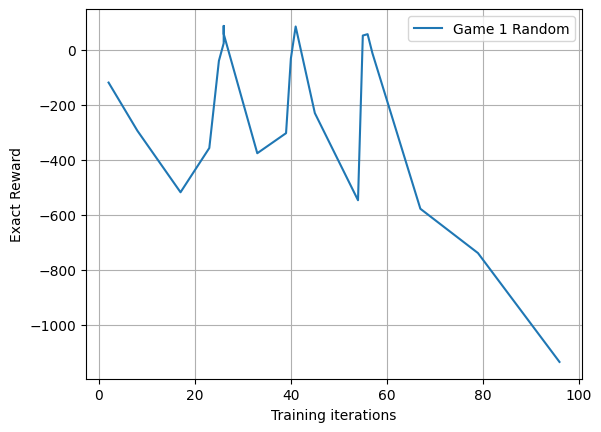

In [8]:
import matplotlib.pyplot as plt
plt.plot(ep_num, rewards, label="Game 1 Random")       
# plt.scatter(scat_iter, scat_value, label="torch collected", marker='x')
plt.xlabel("Training iterations")
plt.ylabel("Exact Reward")
plt.legend(loc=1)
plt.grid(True)
plt.show()